**Dataset Acquisition**

This dataset contains images of external body injuries and normal skin.
Multiple wound categories (abrasions, burns, cuts, bruises, etc.) are grouped
into a single "Injury" class for binary classification, while normal skin images
form the "Normal" class.

This design supports a medical screening use case, where the objective is to
detect the presence of injury before detailed categorization.


CELL 1: Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


CELL 2: Dataset Path & Structure Check

In [2]:
DATA_DIR = "/kaggle/input/wound-dataset-combined/Wound_dataset copy"
print(os.listdir(DATA_DIR))

['Abrasions', 'Cut', 'Burns', 'Normal', 'Laseration', 'Diabetic Wounds', 'Pressure Wounds', 'Surgical Wounds', 'Bruises', 'Venous Wounds']


CELL 3: Build Binary Labels

In [3]:
base_dataset = datasets.ImageFolder(DATA_DIR)

class_names = base_dataset.classes
print("Original classes:", class_names)

targets = []
for path, label in base_dataset.samples:
    class_name = class_names[label]
    if class_name.lower() == "normal":
        targets.append(0)   # Normal
    else:
        targets.append(1)   # Injury

targets = np.array(targets)

# Sanity check
unique, counts = np.unique(targets, return_counts=True)
print("Binary label distribution:", dict(zip(unique, counts)))


Original classes: ['Abrasions', 'Bruises', 'Burns', 'Cut', 'Diabetic Wounds', 'Laseration', 'Normal', 'Pressure Wounds', 'Surgical Wounds', 'Venous Wounds']
Binary label distribution: {np.int64(0): np.int64(2292), np.int64(1): np.int64(2740)}


CELL 4: Stratified Train / Val / Test Split

In [4]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(targets))

# 70% train, 30% temp
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices,
    targets,
    test_size=0.30,
    stratify=targets,
    random_state=42
)

# Split temp into 15% val, 15% test
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)


CELL 5: Verify Split Distributions

In [5]:
def show_split(name, y):
    unique, counts = np.unique(y, return_counts=True)
    print(f"{name} split:", dict(zip(unique, counts)))

show_split("Train", y_train)
show_split("Validation", y_val)
show_split("Test", y_test)


Train split: {np.int64(0): np.int64(1604), np.int64(1): np.int64(1918)}
Validation split: {np.int64(0): np.int64(344), np.int64(1): np.int64(411)}
Test split: {np.int64(0): np.int64(344), np.int64(1): np.int64(411)}


## Data Preprocessing

This section describes how input images are resized, normalized, and augmented
before being passed to the model. Separate preprocessing pipelines are used for
training and evaluation data to prevent data leakage.


CELL 6: Define Image Transforms

In [8]:
IMG_SIZE = 224

# Strong augmentation for NORMAL images
normal_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.05
    ),
    transforms.RandomResizedCrop(
        IMG_SIZE, scale=(0.8, 1.0)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Mild augmentation for INJURY images
injury_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation / Test (NO augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


CELL 7: Create Dataset + Subsets

In [11]:
# CELL 7 (DEPRECATED)
# This cell is intentionally disabled because we now use
# BinaryWoundDataset with class-specific transforms (Cell 10–11).


CELL 8: Create DataLoaders

In [14]:
# CELL 8 (DEPRECATED)
# DataLoaders are now created in Cell 12


CELL 9: Sanity Check Loader Outputs

In [16]:
# CELL 9 (DEPRECATED)
# Sanity check is now performed in Cell 13


**FIX: Custom Binary Dataset**
CELL 10: Define Custom Dataset

In [18]:
from torch.utils.data import Dataset

class BinaryWoundDataset(Dataset):
    def __init__(
        self,
        imagefolder_dataset,
        indices,
        binary_targets,
        normal_transform=None,
        injury_transform=None
    ):
        self.dataset = imagefolder_dataset
        self.indices = indices
        self.targets = binary_targets
        self.normal_transform = normal_transform
        self.injury_transform = injury_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, _ = self.dataset[real_idx]
        label = self.targets[real_idx]

        if label == 0 and self.normal_transform is not None:
            image = self.normal_transform(image)
        elif label == 1 and self.injury_transform is not None:
            image = self.injury_transform(image)

        return image, label


## Binary Dataset Construction

A custom dataset wrapper is used to apply binary labels (Normal vs Injury) and
ensure that appropriate preprocessing is applied consistently across training,
validation, and test splits.


CELL 11: Rebuild Datasets Using Binary Labels

In [19]:
# Rebuild datasets using the custom BinaryWoundDataset
# This ensures:
# - Correct binary labels
# - Correct preprocessing per split

base_dataset = datasets.ImageFolder(DATA_DIR)

train_dataset = BinaryWoundDataset(
    base_dataset,
    train_idx,
    targets,
    normal_transform=normal_transform,
    injury_transform=injury_transform
)

val_dataset = BinaryWoundDataset(
    base_dataset,
    val_idx,
    targets,
    normal_transform=val_transform,
    injury_transform=val_transform
)

test_dataset = BinaryWoundDataset(
    base_dataset,
    test_idx,
    targets,
    normal_transform=val_transform,
    injury_transform=val_transform
)


CELL 12: Rebuild DataLoaders

In [21]:
# DataLoaders handle batching and shuffling

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)


CELL 13: VERIFY LABELS

In [22]:
# Final verification to ensure:
# - Correct tensor shapes
# - Binary labels are correctly applied
# - Both classes appear in training batches

images, labels = next(iter(train_loader))
print(images.shape)
print("Sample labels:", labels[:10].numpy())
print("Unique labels:", np.unique(labels.numpy()))



torch.Size([32, 3, 224, 224])
Sample labels: [1 0 0 0 0 0 0 1 0 1]
Unique labels: [0 1]


## Handling Class Imbalance

The dataset exhibits a significant imbalance between normal and injured images.
To prevent model bias toward the majority class, class imbalance handling
techniques are applied during training.


CELL 14: Compute Class Weights

In [23]:
from collections import Counter

# Count number of samples per class
class_counts = Counter(targets)
print("Class counts:", class_counts)

# Inverse frequency weighting to handle class imbalance
# Minority class receives higher weight to reduce bias
weight_normal = 1.0 / class_counts[0]
weight_injury = 1.0 / class_counts[1]

class_weights = torch.tensor(
    [weight_normal, weight_injury],
    dtype=torch.float
)

print("Class weights:", class_weights)


Class counts: Counter({np.int64(1): 2740, np.int64(0): 2292})
Class weights: tensor([0.0004, 0.0004])


CELL 15: Define Loss with Class Weights

In [24]:
# Select computation device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Apply class weights to loss function to handle class imbalance
# This penalizes misclassification of the minority class (Normal)
class_weights = class_weights.to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


Using device: cuda


## Model Architecture and Training Strategy

This section defines the convolutional neural network architecture and
training approach used for external injury detection. Transfer learning
is employed to leverage pretrained visual features while minimizing
overfitting on a limited medical dataset.


CELL 16: Define the Model (MobileNetV2)

In [25]:
import torch.nn as nn
from torchvision import models
from torchvision.models import MobileNet_V2_Weights

# Load MobileNetV2 with ImageNet-pretrained weights
# MobileNetV2 is lightweight and well-suited for medical image screening
weights = MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)

# Freeze all convolutional layers (feature extractor)
# This preserves learned low-level features and reduces overfitting
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head for binary classification (Normal vs Injury)
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    2
)

# Move model to CPU/GPU
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 112MB/s] 


CELL 17: Optimizer

In [26]:
# Optimizer updates only the classifier head
# Backbone remains frozen as part of transfer learning strategy
optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=0.001
)


## Model Training and Validation

The model is trained using a supervised learning approach with a separate
validation set to monitor generalization performance and prevent overfitting.


CELL 18: Training + Validation Loop

In [27]:
from tqdm import tqdm

EPOCHS = 8

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # ---------------- TRAINING PHASE ----------------
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Track training statistics
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ---------------- VALIDATION PHASE ----------------
    model.eval()
    val_correct, val_total = 0, 0

    # Disable gradient computation during validation
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Val Acc: {val_acc:.4f}")



Epoch 1/8


100%|██████████| 111/111 [00:40<00:00,  2.76it/s]


Train Loss: 33.0459 | Train Acc: 0.9012
Val Acc: 0.9113

Epoch 2/8


100%|██████████| 111/111 [00:26<00:00,  4.24it/s]


Train Loss: 19.2824 | Train Acc: 0.9378
Val Acc: 0.9285

Epoch 3/8


100%|██████████| 111/111 [00:26<00:00,  4.19it/s]


Train Loss: 16.2508 | Train Acc: 0.9492
Val Acc: 0.9377

Epoch 4/8


100%|██████████| 111/111 [00:25<00:00,  4.27it/s]


Train Loss: 15.2675 | Train Acc: 0.9480
Val Acc: 0.9457

Epoch 5/8


100%|██████████| 111/111 [00:25<00:00,  4.28it/s]


Train Loss: 13.0351 | Train Acc: 0.9577
Val Acc: 0.9430

Epoch 6/8


100%|██████████| 111/111 [00:25<00:00,  4.32it/s]


Train Loss: 12.2535 | Train Acc: 0.9571
Val Acc: 0.9523

Epoch 7/8


100%|██████████| 111/111 [00:26<00:00,  4.26it/s]


Train Loss: 14.1932 | Train Acc: 0.9534
Val Acc: 0.9430

Epoch 8/8


100%|██████████| 111/111 [00:26<00:00,  4.23it/s]


Train Loss: 14.5467 | Train Acc: 0.9608
Val Acc: 0.9616


## Model Evaluation Metrics

The trained model is evaluated on a held-out test set using multiple
performance metrics to provide a comprehensive assessment of its
classification behavior.


**TEST SET EVALUATION**
CELL 19: Test Evaluation (Metrics)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Evaluate performance on the TEST set
# Test set is not used during training or validation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report includes:
# - Precision
# - Recall
# - F1-score
# for both Normal and Injury classes
print(classification_report(
    all_labels,
    all_preds,
    target_names=["Normal", "Injury"]
))


              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94       344
      Injury       0.95      0.95      0.95       411

    accuracy                           0.95       755
   macro avg       0.95      0.95      0.95       755
weighted avg       0.95      0.95      0.95       755



## Confusion Matrix Analysis

A confusion matrix is used to analyze classification outcomes in detail,
highlighting correct predictions and different types of errors.


## Error Analysis and Edge Case Identification

Beyond aggregate performance metrics, error analysis is performed to
understand the types of misclassifications made by the model and their
potential impact in real-world medical screening scenarios.


CELL 20: Confusion Matrix (Point 6 – Error Analysis)

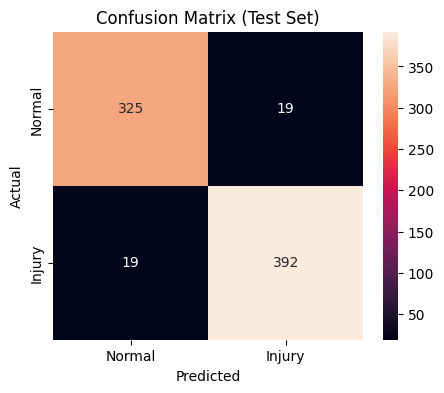

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix summarizes prediction outcomes:
# - True Positives
# - True Negatives
# - False Positives
# - False Negatives
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Normal", "Injury"],
    yticklabels=["Normal", "Injury"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Confusion matrix interpretation:
# - False Negatives (Injury predicted as Normal) are critical in medical screening
# - False Positives (Normal predicted as Injury) may cause unnecessary follow-up



## Model Interpretability and Explainability

To ensure transparency and trust in model predictions, interpretability
techniques are applied to visualize which regions of an image influence
the model’s decision.


CELL 21: Grad-CAM Setup (clean version)

In [30]:
# Grad-CAM implementation to provide visual explanations for model predictions.
# This technique highlights image regions that contribute most to a given class decision,
# enabling interpretability for medical professionals.


import cv2
import torch.nn.functional as F


In [31]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Forward hook
        self.target_layer.register_forward_hook(self._forward_hook)
        # Backward hook (modern & safe)
        self.target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx):
        # Compute importance weights by global average pooling of gradients

        self.model.zero_grad()

        output = self.model(input_tensor)
        output[0, class_idx].backward()

        # Safety check
        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients or activations not captured")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam) # Apply ReLU to focus only on features positively influencing the prediction


        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam


CELL 22: Initialize Grad-CAM

In [32]:
# Use the final convolutional layer of MobileNetV2 for Grad-CAM
# This layer retains spatial information necessary for localization
target_layer = model.features[-1][0]
gradcam = GradCAM(model, target_layer)


CELL 23: Apply Grad-CAM to a Test Image

In [33]:
# Grad-CAM is later used to visually inspect model focus regions.
# This helps explain misclassifications and edge cases during error analysis.


import random

model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)
images.requires_grad = True

outputs = model(images)
preds = outputs.argmax(dim=1)

labels_cpu = labels.cpu()
preds_cpu = preds.cpu()

# Get indices of correctly predicted injury samples
valid_indices = ((labels_cpu == 1) & (preds_cpu == 1)).nonzero(as_tuple=True)[0]

# Randomly choose one
idx = random.choice(valid_indices.tolist())

input_img = images[idx].unsqueeze(0)
pred_class = preds[idx].item()

cam = gradcam.generate(input_img, pred_class)
cam = cam.squeeze().cpu().numpy()


## Grad-CAM Visualization

Grad-CAM heatmaps are visualized alongside original images to help medical
personnel understand the basis of the model’s predictions.


Cell 24: Visualize the Grad-CAM heatmap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011073320431032162..1.0000000059604646].


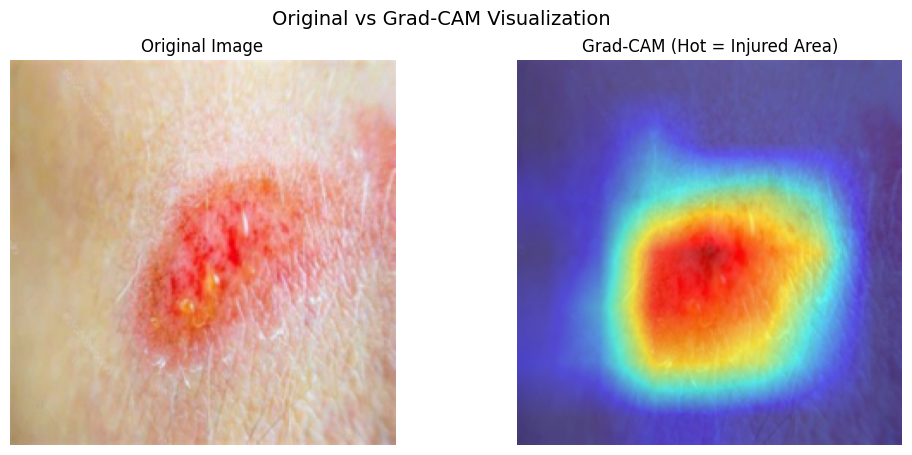

In [34]:
# Visualization of Grad-CAM results
# Warmer colors (red/yellow) indicate regions with higher influence
# Cooler colors indicate less relevant regions

import cv2
import matplotlib.pyplot as plt
import numpy as np

# ----- Prepare original image -----
orig_img = input_img.squeeze().detach().permute(1, 2, 0).cpu().numpy()
orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())

# ----- Invert CAM so HOT = important -----
cam_inverted = 1 - cam

# Resize CAM to image size
heatmap = cv2.resize(cam_inverted, (orig_img.shape[1], orig_img.shape[0]))

# Apply colormap (JET: blue → red)
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay heatmap on image
overlay = 0.6 * heatmap / 255 + 0.4 * orig_img

# ----- Side-by-side visualization -----
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM (Hot = Injured Area)")
plt.axis("off")

plt.suptitle("Original vs Grad-CAM Visualization", fontsize=14)
plt.show()


In [36]:
torch.save(model.state_dict(), "injury_model.pth")
print("Model saved")


Model saved
